<a href="https://colab.research.google.com/github/Salma-Jamal/NADA2020-SharedTask/blob/main/NADI-Experiments/NADI2020_Finetune_multi_dialect_bert_base_arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
!pip install -q transformers
!pip install -q datasets
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from transformers import TrainerCallback
from copy import deepcopy
from datasets import load_metric
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np        
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
from PIL import Image
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report



#Download Data

In [ ]:
!wget https://cdn.discordapp.com/attachments/778630432878362676/1066138952047808512/train_labeled.tsv

In [ ]:
!wget https://cdn.discordapp.com/attachments/778630432878362676/1066138956942545026/dev_labeled.tsv

# Read Data

In [ ]:
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
df_train = pd.read_table('/content/train_labeled.tsv')
df_val = pd.read_table('/content/dev_labeled.tsv')
df_train.columns = ['tweet_ID'	,'text'	,'dialect','province_label']
df_val.columns = ['tweet_ID'	,'text'	,'dialect','province_label']

In [ ]:
df_train.head()

,tweet_ID,text,dialect,province_label
0,TRAIN_1,الفار العور يشوف فقط كيسي ومايشوف ماتويد,Iraq,iq_Al-Anbar
1,TRAIN_2,ي دينيييي ربنا يستر,Egypt,eg_Alexandria
2,TRAIN_3,أساساً نسبكم قذر ونجس بلاش تتفاخروا بنجاستكم ي...,Iraq,iq_Maysan
3,TRAIN_4,ليْسَت كُل المَشَاعِرِ تَحْتَاجُ إلى حَبِيب بَ...,Morocco,ma_Oriental
4,TRAIN_5,لأ ني حاضرها هذي لايف,Libya,ly_Al-Jabal-al-Akhdar


In [ ]:
df_val.head()

,tweet_ID,text,dialect,province_label
0,Dev_1,@Osama__zahrani ايسكو لاعب اليوم :) اسيست وهدف,Iraq,iq_Ninawa
1,Dev_2,بعد صلاه الفجر بقا,Egypt,eg_Monufia
2,Dev_3,إن شاء الله هذه المرة يكون من نصيبي,Algeria,dz_Oran
3,Dev_4,ههههههههههههههههه خلي السوداني يزغبك,Yemen,ye_Al-Hudaydah
4,Dev_5,كل حاجة محسوبة يا جماعة والله,Egypt,eg_South-Sinai


In [ ]:
len(df_train) , len(df_val)

(21000, 4957)

#Preparing data and model

In [ ]:
df_train['dialect'].unique()

array(['Iraq', 'Egypt', 'Morocco', 'Libya', 'United_Arab_Emirates',
       'Mauritania', 'Saudi_Arabia', 'Bahrain', 'Syria', 'Djibouti',
       'Lebanon', 'Oman', 'Palestine', 'Algeria', 'Somalia', 'Jordan',
       'Tunisia', 'Kuwait', 'Yemen', 'Sudan', 'Qatar'], dtype=object)

In [ ]:
class_name = ['Iraq', 'Egypt', 'Morocco', 'Libya', 'United_Arab_Emirates',
       'Mauritania', 'Saudi_Arabia', 'Bahrain', 'Syria', 'Djibouti',
       'Lebanon', 'Oman', 'Palestine', 'Algeria', 'Somalia', 'Jordan',
       'Tunisia', 'Kuwait', 'Yemen', 'Sudan', 'Qatar']

def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(14, 10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="twilight",cbar=False)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Dialect')
  plt.xlabel('Predicted Dialect');
  plt.title('Confusion Matrix of Predictions')

In [ ]:
encode_labels = {d: i for i, d in enumerate(df_train['dialect'].unique())}

In [ ]:
df_train['dialect'] = df_train['dialect'].map(encode_labels)
df_val['dialect'] = df_val['dialect'].map(encode_labels)

In [ ]:
df_train.head()

,tweet_ID,text,dialect,province_label
0,TRAIN_1,الفار العور يشوف فقط كيسي ومايشوف ماتويد,0,iq_Al-Anbar
1,TRAIN_2,ي دينيييي ربنا يستر,1,eg_Alexandria
2,TRAIN_3,أساساً نسبكم قذر ونجس بلاش تتفاخروا بنجاستكم ي...,0,iq_Maysan
3,TRAIN_4,ليْسَت كُل المَشَاعِرِ تَحْتَاجُ إلى حَبِيب بَ...,2,ma_Oriental
4,TRAIN_5,لأ ني حاضرها هذي لايف,3,ly_Al-Jabal-al-Akhdar


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bashar-talafha/multi-dialect-bert-base-arabic', num_labels=len(df_train['dialect'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('bashar-talafha/multi-dialect-bert-base-arabic')

Some weights of the model checkpoint at bashar-talafha/multi-dialect-bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
sequence = []
for i in df_train['text'].tolist():
  sequence.append(len(tokenizer.encode(i)))
max_seq_len = max(sequence)

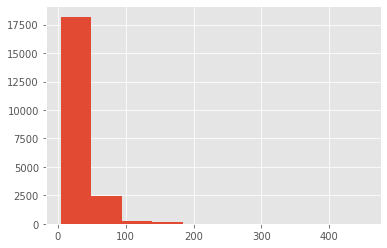

In [ ]:
plt.hist(sequence);

In [ ]:
max_seq_len = 80

In [ ]:
train = tokenizer(df_train['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val= tokenizer(df_val['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
train_labels = df_train['dialect']
val_labels = df_val['dialect']

In [ ]:
class NADIDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)


In [ ]:
ds_train = NADIDataset(train, train_labels)
ds_val =  NADIDataset(val, val_labels)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  f1 = f1_score(labels, predictions, average='macro')
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
      'f1': f1
  }

In [ ]:
class CustomCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=4,              
    per_device_train_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,              
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,                    
    compute_metrics=compute_metrics
)

trainer.add_callback(CustomCallback(trainer)) 

#Training

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 21000
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1316
  Number of trainable parameters = 110633493


Step,Training Loss
500,2.257000
1000,1.615600


Saving model checkpoint to ./results/checkpoint-329
Configuration saved in ./results/checkpoint-329/config.json
Model weights saved in ./results/checkpoint-329/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-658
Configuration saved in ./results/checkpoint-658/config.json
Model weights saved in ./results/checkpoint-658/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-987
Configuration saved in ./results/checkpoint-987/config.json
Model weights saved in ./results/checkpoint-987/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1316
Configuration saved in ./results/checkpoint-1316/config.json
Model weights saved in ./results/checkpoint-1316/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1316, training_loss=1.7440071221905276, metrics={'train_runtime': 1026.4688, 'train_samples_per_second': 81.834, 'train_steps_per_second': 1.282, 'total_flos': 3453921717120000.0, 'train_loss': 1.7440071221905276, 'epoch': 4.0})

# Testing

In [ ]:
preds = trainer.predict(ds_val)

***** Running Prediction *****
  Num examples = 4957
  Batch size = 8


In [ ]:
y_pred = [ np.argmax(i, axis=-1) for i  in preds[0]]
y_test = ds_val.labels

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.26209043549551814

In [ ]:
accuracy_score(y_test, y_pred)

0.44079080088763367

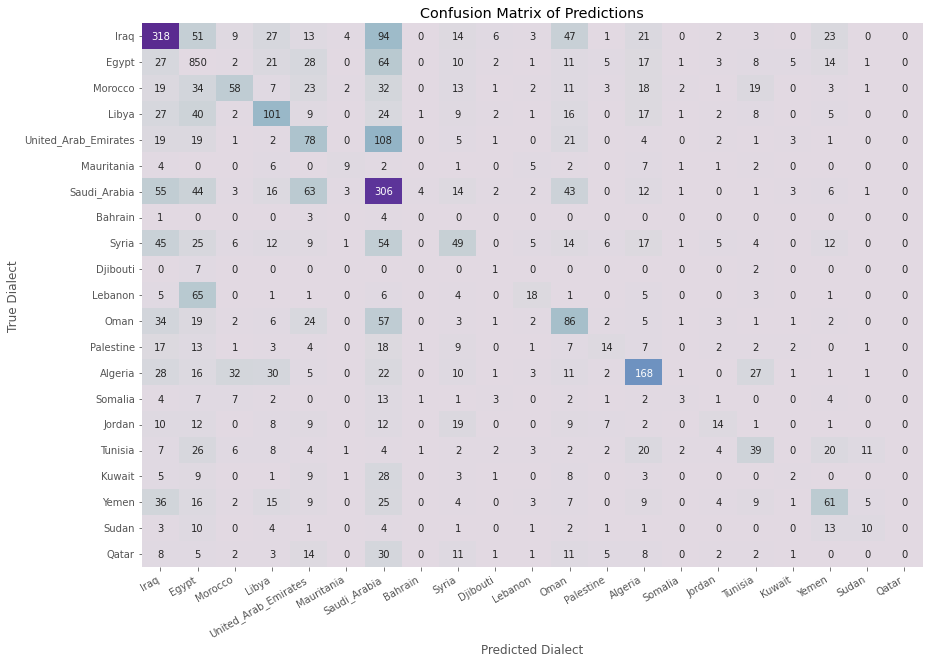

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

## Save model checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model('./multi-dialect-bert-base-arabic_4epochsSL80')

Saving model checkpoint to ./multi-dialect-bert-base-arabic_4epochsSL80
Configuration saved in ./multi-dialect-bert-base-arabic_4epochsSL80/config.json
Model weights saved in ./multi-dialect-bert-base-arabic_4epochsSL80/pytorch_model.bin


In [ ]:
!cp -r /content/multi-dialect-bert-base-arabic_4epochsSL80 /content/drive/MyDrive/multi-dialect-bert-base-arabic_4epochsSL80

#Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bashar-talafha/multi-dialect-bert-base-arabic')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bashar-talafha--multi-dialect-bert-base-arabic/snapshots/f84ad96a07fa1aa6ba176e6e1cea85c4105b663f/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bashar-talafha--multi-dialect-bert-base-arabic/snapshots/f84ad96a07fa1aa6ba176e6e1cea85c4105b663f/config.json
Model config BertConfig {
  "_name_or_path": "bashar-talafha/multi-dialect-bert-base-arabic",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "mo

In [ ]:
inf_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/multi-dialect-bert-base-arabic_4epochsSL80")
inf_trainer = Trainer(
    model=inf_model,                       
    args=training_args,                 
    train_dataset=ds_train,                     
    compute_metrics=compute_metrics
)
inf_preds = inf_trainer.predict(ds_val)

loading configuration file /content/drive/MyDrive/multi-dialect-bert-base-arabic_4epochsSL80/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/multi-dialect-bert-base-arabic_4epochsSL80",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
  

In [ ]:
y_pred = [ np.argmax(i, axis=-1) for i  in inf_preds[0]]
y_test = ds_val.labels

In [ ]:
print('F1-Score =  ',f1_score(y_test, y_pred, average='macro')*100,"%")
print('Accuracy = ',accuracy_score(y_test, y_pred)*100,"%")

F1-Score =   26.209043549551815 %
Accuracy =  44.07908008876337 %


In [ ]:
def predict(Trainer,tokenizer,sentence):
  data = [[0, sentence]]
  inf_df = pd.DataFrame(data, columns = ['dialect', 'text'])
  test_labels = inf_df['dialect']
  test_encodings = tokenizer(inf_df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = NADIDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return list(encode_labels.keys())[list(encode_labels.values()).index(pred[0])]

In [ ]:
predict(inf_trainer,tokenizer,"والنبي انتي عسل ودمك زي السكر")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


'Egypt'

In [ ]:
predict(inf_trainer,tokenizer,"شكله زي هيك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


'Palestine'